In [23]:
%reset-f
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)

from sorted_nicely import *
from res_ind_lib import *
from wb_api_wraper import *
from replace_with_warning import *

In [25]:
def make_tiers(series,labels=["Low","Mid","High"]):
    return pd.cut(series,[series.min()-1e3]+series.quantile([1/3,2/3]).tolist()+[series.max()+1e3],labels=labels).sort_values() #This magically orders the in the "Low", "Mid", "High" order, i wonder why
    

In [26]:
#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 10)
pd.set_option('display.max_rows', 500)


# Data

In [27]:
data_rio= pd.read_excel("inputs/Resilience Indicator_June 22.xlsx", sheetname="Consolidated (2012)",header=1, index_col="Province" );
data_rio.index = data_rio.index.str.title()

data_rio.head()

,Region,Region PSGC,Province PSGC,GRDPC 2012 (At Current Prices),Projected Population 2012,"Average Annual Family Income, 2009","Average Annual Family Income, by Region, 2012",% Wages and salaries 2012,% Entrepreneurial activities 2012,% Other sources of income 2012,...,% Others Deposits 2012,% Health Expenditure 2012,% of Births by Attended Skilled Health Personnel 2012,% hh with radio 2012,% hh with landlines 2012,% hh with cellular phones 2012,"Public Schools, Elementary, 2012-2013","Public Schools, Secondary, 2012-2013",Estimated QRF 2012,Estimated LDRRM Fund 2012
Province,,,,,,,,,,,,,,,,,,,,,
Abra,CAR,14,1401,126843,240135.2441214244,133688,257000,34.3701012485,24.7625546355,29.7152499862,...,0.2270179376,3.1413969336,85.7720119098,65.2173913043,6.2111801242,95.3416149068,277,33,31746830.1432000026,1.0582276714e+08
Agusan Del Norte,CARAGA,16,1602,48954,661728.4543751733,179014,180000,38.7499524914,22.4497358519,29.8354300483,...,0.0044594934,3.4563444311,92.1444550975,39.5744680851,2.7659574468,82.1276595745,293,86,40128811.0972499996,1.3376270366e+08
Agusan Del Sur,CARAGA,16,1603,48954,677779.6821543596,126492,180000,38.7499524914,22.4497358519,29.8354300483,...,0.0551543859,3.4563444311,72.7441562600,39.5744680851,2.7659574468,82.1276595745,483,95,50795871.2119500041,1.6931957071e+08
Aklan,6,6,604,57801,554414.4424224466,119962,202000,37.1111337180,19.5985990205,37.4721330059,...,0.0133418425,4.4318407759,80.6175854850,54.8898071625,6.9559228650,82.3002754821,320,70,34597652.2162500024,1.1532550739e+08
Albay,5,5,505,38870,1264097.8949656591,158629,162000,38.4548298884,21.1662683846,33.5946392057,...,0.3676968374,3.2568098140,84.0840011053,51.4018691589,2.4299065421,80.0000000000,601,122,61822427.3272500038,2.0607475776e+08


#### pov_head, 	unemp, 	plgp, 	pop, 	bashs,	ophe, 	gdp_pc_pp

In [28]:
#Data immeditaly transformable
data_source_matching =pd.read_csv("inputs/data_source_matching.csv").dropna().set_index("rio_name").squeeze().to_dict()
df=data_rio[list(data_source_matching.keys())].rename(columns=data_source_matching)
#transofmring percentages into fractions
df[["pov_head","unemp","plgp","bashs","ophe","shew"]]/=100
df.head()

#Changing the unit of GDP to reduce float overflows
df["gdp_pc_pp"]/=1e3

#Value for computing W'
df["gdp_pc_pp_nat"] = np.average(df.dropna().gdp_pc_pp,weights=df.dropna()["pop"])

df["gdp_pc_pp_ref"] = df["gdp_pc_pp"]
df["pov_head_ref"] = df["pov_head"]


In [29]:
#acces to health as an average
df["axhealth"]=(df.bashs+(1-df.ophe))/2

### Access to finance

In [30]:
df.drop(["Laguna", "Lanao Del Norte"],inplace=True) #provinces with bad data

In [31]:
df["axfin_p"]=df["axfin_r"]=data_rio["%Savings Deposit 2012"]/100

### Livelihoods

In [32]:
df["social_p"]=df["social_r"]=data_rio[["% Other sources of income 2012","% Other receipts 2012"]].sum(axis=1)/100

### Income

0.2879227248212722

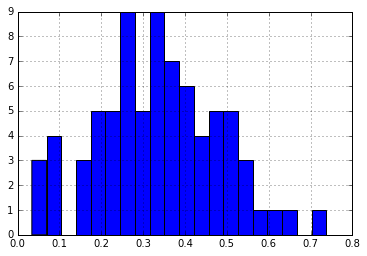

In [33]:
nat_pov_head = (df["pov_head"]*df['pop']/df["pop"].sum()).sum()
df.pov_head.hist(bins=20)
nat_pov_head

(49.41085352233378, 181.76135402858498)

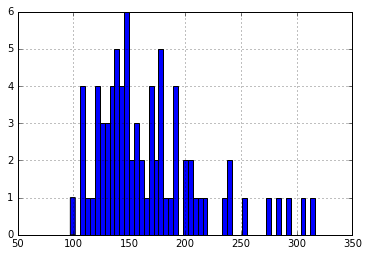

In [34]:
wnat =  (df["gdp_pc_pp"]*df['pop']/df["pop"].sum()).sum() #national income in that currency
wp = 28/103 * wnat #relative income of the 28% poorest compared to national average according to povcalnet
df.gdp_pc_pp.hist(bins=50)
wp, wnat

In [35]:
#Relative income of the province and poor families in those provinces
df["rel_gdp_pp"]=df["gdp_pc_pp"]/df["gdp_pc_pp_nat"]
df["share1"]=wp/df["gdp_pc_pp"]


In [36]:
#assumption on the scale up target
df["scale_up_target"]=0.5

### Financial and institutional preparedness from HFA and soveriegn debt ratings

#### HFA

In [37]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

# READ THE LAST HFA DATA
hfa_newest =   pd.read_csv("inputs/HFA_all_2011_2013.csv")
hfa_newest["country"]=replace_with_warning(hfa_newest["Country name"],any_to_wb)

# READ THE PREVIOUS HFA DATA
hfa_previous = pd.read_csv("inputs/HFA_all_2009_2011.csv")
hfa_previous["country"]=replace_with_warning(hfa_previous["Country name"],any_to_wb)

#most recent values... if no 2011-2013 reporting, we use 2009-2011
hfa_oldnew=pd.concat([hfa_newest.set_index("country"), hfa_previous.set_index("country")], axis=1,keys=['new', 'old'])
hfa = hfa_oldnew["new"].fillna(hfa_oldnew["old"]);

# ability to scale up = average of priority for action 5 of the HFA
hfa["prepare_scaleup"]=(hfa["P4-C2"]+hfa["P5-C2"]+hfa["P4-C5"])/3/5 # between zero and 1
hfa["finance_pre"] = hfa["P5-C3"]/5 #betwenn 0 and 1


df=df.assign(**hfa.ix["Philippines",["prepare_scaleup","finance_pre"]])

#### Country Ratings

In [38]:
any_to_wb=pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

In [39]:
#Reads the data and check its not too old
the_credit_rating_file ="inputs/cred_rat.csv"
nb_weeks = (time.time()-os.stat(the_credit_rating_file).st_mtime )/(3600*24*7)
if nb_weeks>3: 
    warnings.warn("Credit ratings are "+str(int(nb_weeks))+" weeks old. Get new ones at http://www.tradingeconomics.com/country-list/rating")
ratings_raw  =pd.read_csv(the_credit_rating_file,dtype="str").dropna(how="all")
ratings_raw=ratings_raw.rename(columns={"Unnamed: 0": "country_in_ratings"})[["country_in_ratings","S&P","Moody's","Fitch"]]

#The creidt rating sources calls DR Congo just Congo
ratings_raw.country_in_ratings= ratings_raw.country_in_ratings.str.strip().replace(["Congo"],["Congo, Dem. Rep."])

ratings_raw["country"]= replace_with_warning(ratings_raw.country_in_ratings.apply(str.strip),any_to_wb)

ratings_raw=ratings_raw.set_index("country")

def mystriper(string):
    """strip blanks and converts everythng to lower case"""
    if type(string)==str:
        return str.strip(string).lower()
    else:
        return string
        
#to lower case and strips blanks
ratings_raw=ratings_raw.applymap(mystriper)    

#Transforms ratings letters into 1-100 numbers
rat_disc = pd.read_csv("inputs/cred_rat_dict.csv")
ratings=ratings_raw
ratings["S&P"].replace(rat_disc["s&p"].values,rat_disc["s&p_score"].values,inplace=True)
ratings["Moody's"].replace(rat_disc["moodys"].values,rat_disc["moodys_score"].values,inplace=True)
ratings["Fitch"].replace(rat_disc["fitch"].values,rat_disc["fitch_score"].values,inplace=True)
ratings["rating"]=ratings.mean(axis=1)/100

phil_rating = ratings.ix["Philippines","rating"]
df["rating"]=phil_rating

C:\Users\Admin\Box Sync\PYTHON - RESILIENCE\resilience_indicator_phl\replace_with_warning.py:7: UserWarning: bad country names:European Union
  warnings.warn("bad country names:" +",".join(bads))


#### Combining

In [40]:
df["borrow_abi"]=(df["rating"]+df["finance_pre"])/2 
df["sigma_p"]=df["sigma_r"]=df["scale_up_target"]*(df["borrow_abi"]+df["prepare_scaleup"])/2

### Capital data from Penn tables

In [41]:
#data arranged from Penn tables
k_data=pd.read_csv("inputs/capital_data.csv")[["code","cgdpo","ck"]].replace({"ROM":"ROU","ZAR":"COD"}).rename(columns={"cgdpo":"prod_from_k","ck":"k"})#Zair is congo

#matches names in the dataset with world bank country names
iso_country = pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3")
k_data.set_index("code",inplace=True)
k_data["country"]=iso_country["country"]
cond = k_data["country"].isnull()
if cond.sum()>0:
     warnings.warn("this countries appear to be missing from iso3_to_wb_name.csv: "+" , ".join(k_data.index[cond].values))
k_data=k_data.reset_index().set_index("country")

# average productivity of capital
df["avg_prod_k"]=(k_data["prod_from_k"]/k_data["k"]).ix["Philippines"]


### Exposure (population in flood-prone areas)

In [42]:
#Data from Glofris
pop_exposed = pd.read_csv("inputs/pop_exposed.csv",index_col=["NAME_1"])
pop_exposed.index=pop_exposed.index.str.title()

df["faref"]=df["fa"]=pop_exposed["rp10_pop"]

fa_ratios =pop_exposed.div(df["fa"],axis=0)
fa_ratios.columns=["fa_ratio_10","fa_ratio_100"]


fa_ratios["fa_ratio_5"]=fa_ratios["fa_ratio_10"] #assumes flat exposure before 5 yr rp
fa_ratios.dropna().shape
fa_ratios = fa_ratios.reindex_axis(sorted_nicely(fa_ratios.columns), axis=1)
df[fa_ratios.columns]=fa_ratios

### Vulnerability

In [43]:
#matches roof and wall types to vulnerabilities
roof_types_to_vuln =pd.read_csv("inputs/roof_types_to_vuln.csv").squeeze().sort_values(ascending=False)
wall_types_to_vuln =pd.read_csv("inputs/wall_types_to_vuln.csv").squeeze().sort_values(ascending=False)

roof_types_to_vuln, wall_types_to_vuln

(Roof_% Salvaged/mixed but predominatly salvaged materials 2012    0.7
 Roof_% Light/mixed but predominantly light materials 2012         0.4
 Roof_% Strong/mixed but predominantly strong materials 2012       0.1
 Name: 0, dtype: float64,
 Walls_% alvaged/mixed but predominatly salvaged materials 2012    0.7
 Walls_% Light/mixed but predominantly light materials 2012        0.4
 Walls_% Strong/mixed but predominantly strong materials 2012      0.1
 Name: 0, dtype: float64)

(<matplotlib.axes._subplots.AxesSubplot at 0x8e98a20>,
 <matplotlib.text.Text at 0xa2ee668>)

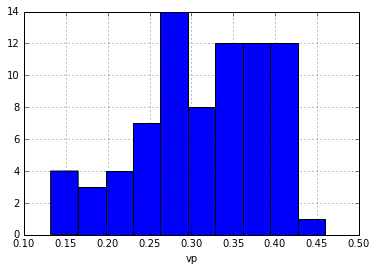

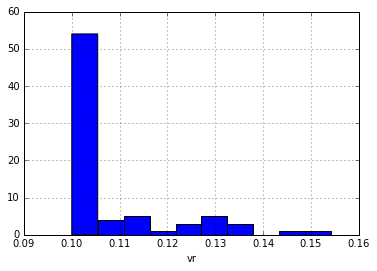

In [44]:
#sorts roof types according to income
share =data_rio[roof_types_to_vuln.keys()]/100
p=(share.cumsum(axis=1).add(-df["pov_head"],axis=0)).clip(lower=0)
poor=(share-p).clip(lower=0)
rich=share-poor

#rooves
vp=0.5* (poor*roof_types_to_vuln).sum(axis=1)/df["pov_head"]
vr=0.5* (rich*roof_types_to_vuln).sum(axis=1)/(1-df["pov_head"])


#sorts wall types according to income
share =data_rio[wall_types_to_vuln.keys()]/100
p=(share.cumsum(axis=1).add(-df["pov_head"],axis=0)).clip(lower=0)
poor=(share-p).clip(lower=0)
rich=share-poor

#walls
vp+=0.5*((poor*wall_types_to_vuln).sum(axis=1)/df["pov_head"] )
vr+=0.5* (rich*wall_types_to_vuln).sum(axis=1)/(1-df["pov_head"])


#plots
vp.hist(), plt.xlabel("vp")
plt.figure()
vr.hist(),plt.xlabel("vr")

In [45]:
#Expresses vulnerability as total and bias

ph=df["pov_head"]

fa=df["fa"]
pe=df["peref"] =df["pe"] = .2
fap=fa*(1+pe)
far=(fa-ph*fap)/(1-ph)

df["share1_ref"]=df["share1"]
cp=   df["share1"] *df["gdp_pc_pp"]
cr=(1-df["share1"])*df["gdp_pc_pp"]

v=df["v"]  = (ph*vp*cp*fap + (1-ph)*vr*cr*far)/(ph*cp*fap + (1-ph)*cr*far)
df["pv"] =  vp/df.v-1

#vulnerability of diversified (shared) capital
df["v_s"]=vr

#df.v .hist()
#df.pv.hist()

# National buyout

In [46]:
#assumption on cross-provincial risk sharing
df["nat_buyout"] = 0.3

### Hazard (protection)

In [47]:
#rough assumption
df["protection"]=5




### Homogenity of losses

In [48]:
#resds loss distribution in mumbai
hop=pd.read_csv("inputs/losses_distribution_mumbai.csv",index_col=0)["losses/asset_cost"]
# standard deviation of the underlying normal distribution
s = np.log(hop).std() 

df["H"]= np.exp (-s**2/2)


## Report missing data by province

In [49]:
def write_missing_data(s):
    which = s[s.isnull()].index.values
    return ", ".join(which)

def count_missing_data(s):
    return s.isnull().sum()

report = pd.DataFrame()

report["nb_missing"]=df.apply(count_missing_data,axis=1)  
report["missing_data"]=df.apply(write_missing_data,axis=1)

report  = report.ix[report["nb_missing"]>0,:]
report.sort_values(by="nb_missing",inplace=True)
report.to_csv("missing_data_report.csv")

report.head()

,nb_missing,missing_data
Province,,
Aklan,5,"fa_ratio_5, fa_ratio_10, fa_ratio_100, v, pv"
Marinduque,5,"fa_ratio_5, fa_ratio_10, fa_ratio_100, v, pv"
Masbate,5,"fa_ratio_5, fa_ratio_10, fa_ratio_100, v, pv"
Misamis Oriental,5,"fa_ratio_5, fa_ratio_10, fa_ratio_100, v, pv"
Mountain Province,5,"fa_ratio_5, fa_ratio_10, fa_ratio_100, v, pv"


## manual parametrization

In [50]:
# no ripple effects
df["alpha"] =1 

#Reconstruction times
df["T_rebuild_K"] = 3
df["T_rebuild_L"] = 40

# how much early warning reduces vulnerability
df["pi"] = 0.2

#income elasticity
df["income_elast"] = 1.5

# Computes and saves provincial resilience

#### Central cases

In [51]:
df["original_country"]=df.index;
#saves orginal dataframe before adding columns with results
df.to_csv("df_original.csv")

In [52]:
df_with_results=compute_resiliences(df)
print("nb Provinces with all data :"+str(df.dropna().shape[0]))

nb_countries_all_results = df_with_results["resilience"].dropna().shape[0]
print("nb Provinces with all data and results :"+str(nb_countries_all_results))

df_with_results.to_csv("df.csv")


nb Provinces with all data :35
nb Provinces with all data and results :35


#### Impact of increasing effective scale up

In [53]:
df_su = compute_resiliences( df.dropna().assign(sigma_p=1) )

#welfare losses
wa=df_with_results.total_equivalent_cost.sum()*1e-9
wb=df_su.total_equivalent_cost.sum()*1e-9

#asset losses
ka = (df_with_results.dKtot/df.protection).sum()*1e-9
kb = (df_su.dKtot/df_su.protection).sum()*1e-9

print(" Increasing effective scale up to 100% in the {nb} provincies \
would increase asset losses from USD {ka:0.0f} to {kb:0.0f} billions per year \
(+{XX:.1f} percent), but reduce welfare losses by {YY:.2} percent".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=100*(wa-wb)/wa,nb=nb_countries_all_results)
     )

 Increasing effective scale up to 100% in the 35 provincies would increase asset losses from USD 0 to 0 billions per year (+0.0 percent), but reduce welfare losses by 2.7e+01 percent


#### Impact of decreasing poverty insurance

In [54]:
df_share1 = compute_resiliences( df.dropna().assign(pov_head=df.pov_head-1/100) )

#welfare losses
wa=df_with_results.total_equivalent_cost.sum()*1e-9
wb=df_share1.total_equivalent_cost.sum()*1e-9

#asset losses
ka = (df_with_results.dKtot/df.protection).sum()*1e-9
kb = (df_share1.dKtot/df_share1.protection).sum()*1e-9

print(" Decreasing poverty incidence by 1 percent in the {nb} provincies \
would increase asset losses from USD {ka:0.0f} to {kb:0.0f} billions per year \
(+{XX:.1f} percent), but reduce welfare losses by {YY:.2} percent".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=100*(wa-wb)/wa,nb=nb_countries_all_results)
     )

 Decreasing poverty incidence by 1 percent in the 35 provincies would increase asset losses from USD 0 to 0 billions per year (+-0.2 percent), but reduce welfare losses by 1.2 percent


#### Basic reporting

In [55]:
#Some stats
a=df_with_results.resilience;
a.min()*100,a.mean()*100,a.max()*100
"Resilience averages {mean:.0%} across our sample, ranging from {min:.0%} to {max:.0%}".format(
    min=a.min(),mean=a.mean(),max=a.max())

'Resilience averages 45% across our sample, ranging from 22% to 135%'

In [56]:
#Outputs table with main results
to_output = ['gdp_pc_pp', 'pop',"protection","fa","v","resilience","risk"]
a=df_with_results[to_output].copy()
a.loc[:,["fa","v","resilience","risk"]]=100*a[["fa","v","resilience","risk"]]
desc=pd.read_csv("inputs/inputs_info.csv").set_index('key')["descriptor"]
a.rename(columns=desc).dropna().to_excel("results.xlsx")

# Resilience tiers

In [57]:
pd.DataFrame([make_tiers(df_with_results.resilience), make_tiers(df_with_results.risk)]).T.dropna()

,resilience,risk
Abra,Low,High
Agusan Del Norte,Mid,High
Agusan Del Sur,Low,High
Apayao,Low,Low
Batangas,High,Low
Bukidnon,Low,Mid
Bulacan,High,Low
Cagayan,High,Mid
Camarines Sur,Mid,High
Capiz,Mid,High


In [58]:
#Outputs resilience tiers to excel
with pd.ExcelWriter("tiers.xlsx", engine='xlsxwriter') as writer:
    workbook=writer.book
    # Add a format. Light red fill with dark red text.
    red = workbook.add_format({#'bg_color': '#f4a582',
                                   'font_color': '#ca0020'})
    orange = workbook.add_format({#'bg_color': '#f7f7f7',
                                   'font_color': '#000000'})

    blue = workbook.add_format({#'bg_color': '#92c5de',
                                   'font_color': '#0571b0'})
    pd.DataFrame([make_tiers(df_with_results.resilience), make_tiers(df_with_results.risk)]).T.sort_values(by="risk").to_excel(writer,sheet_name="tiers")
    worksheet=writer.sheets["tiers"]
    worksheet.conditional_format('B2:B600', {'type':     'text',
                                   'criteria': 'containing',
                                'value':    "Low",
                                'format':   red})
    writer.sheets["tiers"].conditional_format('B2:B600', {'type':     'text',
                                'criteria': 'containing',
                                'value':    "High",
                                'format':   blue})
    writer.sheets["tiers"].conditional_format('C2:C600', {'type':     'text',
                                   'criteria': 'containing',
                                'value':    "Low",
                                'format':   blue})
    writer.sheets["tiers"].conditional_format('C2:C600', {'type':     'text',
                                'criteria': 'containing',
                                'value':    "High",
                                'format':   red})
    writer.sheets["tiers"].conditional_format('B2:C600', {'type':     'text',
                                'criteria': 'containing',
                                'value':    "Mid",
                                'format':   orange}) 
    worksheet.autofilter('A1:C1')
    worksheet.set_column(0, 0, 20)
    worksheet.set_column(1, 1, 14)
    worksheet.set_column(2, 2, 8)
    writer.sheets["tiers"].freeze_panes(1, 1)

## sensitivity anlysis

In [59]:
####Sensitivity analysis folling instructions in alt_params.csv

#reads paramters to be varied
alt_params=pd.read_csv("inputs/alt_params.csv")

df_sensit = pd.DataFrame(columns=df.columns)

#for c in country_sens_list:
for c in df.dropna().index[0:5]: #senstitivity for all countries  (actually very long)
    for p in alt_params.index.tolist():
        param = alt_params.ix[p,"param"]
        
        new_value = alt_params.ix[p,"value"]
        if new_value[0] in "/*":
            new_value = str(df.ix[c,param])+new_value         
        new_value = eval(new_value)
        
        d = c+" $({name}={nv:2.0f}\%)$".format(name=alt_params.ix[p,"formated_name"],nv=100*new_value)
        df_sensit.ix[d] = df.ix[c]
        df_sensit.ix[d,param] =new_value
        df_sensit.ix[d,"original_country"]=c
        
        #sets reference values 
        df_sensit =def_ref_values(df_sensit)
        
    
    #special treatment for fa
    df_sensit.ix[d,param] =new_value
    
    for param in ["income_elast"]:
        for new_value in [1, 2]:
            d = c+" $(\eta="+str(new_value)+")$"
            df_sensit.ix[d] = df.ix[c]
            df_sensit.ix[d,param] =new_value
            df_sensit.ix[d,"original_country"]=c

df_sensit.index.name="Province"; #after adding indices pandas forgets their 
df_sensit.to_csv("df_sensit_input.csv")
compute_resiliences(df_sensit).to_csv("df_sensit_results.csv")